In [1]:
# Try to import vrplib and read external files; fallback to embedded copies if needed.
USE_VRPLIB = True
try:
    import vrplib  # pip install vrplib
except Exception as e:
    print("vrplib not available:", e)
    USE_VRPLIB = False

VRP_FILES = {
    "A": "data/A-n32-k5.vrp",
    "B": "data/B-n78-k10.vrp",
    "X": "data/X-n101-k25.vrp",
}

# Embedded fallback strings (only used when vrplib/files unavailable)
EMBED_A = r"""
NAME : A-n32-k5
COMMENT : (Augerat et al, No of trucks: 5, Optimal value: 784)
TYPE : CVRP
DIMENSION : 32
EDGE_WEIGHT_TYPE : EUC_2D 
CAPACITY : 100
NODE_COORD_SECTION 
 1 82 76
 2 96 44
 3 50 5
 4 49 8
 5 13 7
 6 29 89
 7 58 30
 8 84 39
 9 14 24
 10 2 39
 11 3 82
 12 5 10
 13 98 52
 14 84 25
 15 61 59
 16 1 65
 17 88 51
 18 91 2
 19 19 32
 20 93 3
 21 50 93
 22 98 14
 23 5 42
 24 42 9
 25 61 62
 26 9 97
 27 80 55
 28 57 69
 29 23 15
 30 20 70
 31 85 60
 32 98 5
DEMAND_SECTION 
1 0 
2 19 
3 21 
4 6 
5 19 
6 7 
7 12 
8 16 
9 6 
10 16 
11 8 
12 14 
13 21 
14 16 
15 3 
16 22 
17 18 
18 19 
19 1 
20 24 
21 8 
22 12 
23 4 
24 8 
25 24 
26 24 
27 2 
28 20 
29 15 
30 2 
31 14 
32 9 
DEPOT_SECTION 
 1  
 -1  
EOF 
"""

EMBED_B = r"""
NAME : B-n78-k10
COMMENT : (Augerat et al, No of trucks: 10, Optimal value: 1221)
TYPE : CVRP
DIMENSION : 78
EDGE_WEIGHT_TYPE : EUC_2D 
CAPACITY : 100
NODE_COORD_SECTION 
 1 46 12
 2 51 4
 3 52 30
 4 80 70
 5 18 90
 6 59 39
 7 23 59
 8 77 48
 9 82 30
 10 18 82
 11 11 41
 12 7 9
 13 88 33
 14 23 88
 15 0 76
 16 85 34
 17 17 46
 18 52 10
 19 13 45
 20 19 85
 21 86 77
 22 54 6
 23 83 32
 24 15 10
 25 53 5
 26 14 42
 27 13 10
 28 57 32
 29 20 85
 30 65 46
 31 61 42
 32 87 52
 33 79 51
 34 25 91
 35 89 34
 36 26 100
 37 0 88
 38 63 43
 39 55 10
 40 23 86
 41 8 18
 42 0 74
 43 20 44
 44 56 7
 45 14 10
 46 88 40
 47 96 38
 48 59 31
 49 22 87
 50 59 36
 51 24 83
 52 83 37
 53 53 5
 54 0 37
 55 84 78
 56 27 93
 57 61 12
 58 69 43
 59 54 9
 60 20 98
 61 18 50
 62 25 84
 63 31 69
 64 58 36
 65 0 11
 66 61 36
 67 18 49
 68 57 8
 69 0 49
 70 56 8
 71 62 45
 72 83 32
 73 53 10
 74 82 53
 75 21 85
 76 64 41
 77 80 50
 78 16 10
DEMAND_SECTION 
1 0 
2 14 
3 17 
4 17 
5 16 
6 19 
7 17 
8 5 
9 12 
10 4 
11 2 
12 2 
13 26 
14 2 
15 7 
16 18 
17 6 
18 6 
19 18 
20 2 
21 14 
22 5 
23 9 
24 4 
25 3 
26 15 
27 4 
28 23 
29 7 
30 21 
31 4 
32 1 
33 6 
34 16 
35 4 
36 20 
37 5 
38 14 
39 14 
40 26 
41 5 
42 2 
43 14 
44 11 
45 21 
46 20 
47 18 
48 2 
49 19 
50 12 
51 22 
52 14 
53 23 
54 25 
55 8 
56 3 
57 9 
58 21 
59 3 
60 22 
61 6 
62 2 
63 22 
64 20 
65 5 
66 13 
67 6 
68 14 
69 16 
70 12 
71 23 
72 5 
73 12 
74 15 
75 21 
76 4 
77 23 
78 19 
DEPOT_SECTION 
 1  
 -1  
EOF 
"""

EMBED_X = r"""
NAME : 	X-n101-k25	
COMMENT : 	"Generated by Uchoa, Pecin, Pessoa, Poggi, Subramanian, and Vidal (2013)"	
TYPE : 	CVRP	
DIMENSION : 	101	
EDGE_WEIGHT_TYPE : 	EUC_2D	
CAPACITY : 	206	
NODE_COORD_SECTION		
1	365	689
2	146	180
3	792	5
4	658	510
5	461	270
6	299	531
7	812	228
8	643	90
9	615	630
10	258	42
11	616	299
12	475	957
13	425	473
14	406	64
15	656	369
16	202	467
17	318	21
18	579	587
19	458	354
20	575	871
21	47	512
22	568	742
23	128	436
24	546	806
25	197	696
26	615	300
27	852	563
28	772	803
29	678	342
30	916	176
31	390	949
32	113	782
33	226	736
34	119	923
35	584	572
36	134	554
37	912	173
38	827	233
39	851	677
40	598	322
41	627	472
42	94	442
43	688	274
44	977	176
45	597	461
46	931	23
47	170	640
48	941	601
49	873	487
50	797	95
51	451	816
52	866	970
53	833	912
54	106	913
55	260	107
56	332	45
57	685	613
58	728	372
59	487	497
60	702	440
61	717	412
62	635	794
63	927	972
64	635	356
65	634	540
66	658	261
67	303	168
68	707	410
69	254	135
70	346	29
71	75	79
72	893	987
73	729	372
74	29	910
75	356	39
76	274	943
77	322	96
78	664	396
79	704	236
80	415	837
81	576	587
82	750	977
83	726	363
84	861	948
85	302	129
86	415	989
87	199	135
88	801	405
89	679	426
90	994	804
91	311	116
92	739	898
93	268	97
94	176	991
95	688	588
96	107	836
97	708	522
98	679	864
99	985	877
100	954	950
101	615	750
DEMAND_SECTION		
1	0	
2	38	
3	51	
4	73	
5	70	
6	58	
7	54	
8	1	
9	98	
10	62	
11	98	
12	25	
13	86	
14	46	
15	27	
16	17	
17	97	
18	74	
19	81	
20	62	
21	59	
22	23	
23	62	
24	66	
25	35	
26	53	
27	18	
28	87	
29	32	
30	4	
31	61	
32	95	
33	23	
34	15	
35	5	
36	53	
37	97	
38	70	
39	32	
40	27	
41	42	
42	67	
43	76	
44	15	
45	39	
46	14	
47	43	
48	11	
49	93	
50	53	
51	44	
52	80	
53	87	
54	97	
55	67	
56	72	
57	50	
58	8	
59	58	
60	55	
61	67	
62	89	
63	38	
64	65	
65	3	
66	5	
67	46	
68	100	
69	52	
70	28	
71	96	
72	18	
73	16	
74	7	
75	73	
76	76	
77	6	
78	64	
79	39	
80	86	
81	70	
82	14	
83	83	
84	96	
85	43	
86	12	
87	73	
88	2	
89	21	
90	18	
91	55	
92	75	
93	68	
94	100	
95	61	
96	24	
97	40	
98	48	
99	51	
100	78	
101	35	
DEPOT_SECTION		
	1	
	-1	
EOF
"""


## Core Model & Utilities

In [2]:
from dataclasses import dataclass
import re, math, random, time
from typing import List, Tuple, Dict, Any
import numpy as np
import pandas as pd

@dataclass
class CVRPInstance:
    name: str
    capacity: int
    coords: Dict[int, Tuple[float, float]]
    demands: Dict[int, int]
    depot: int
    dimension: int

def parse_embedded(tsplib_text: str) -> CVRPInstance:
    lines = [l.rstrip() for l in tsplib_text.strip().splitlines()]
    name = next((l.split(":",1)[1].strip() for l in lines if l.upper().startswith("NAME")), "UNKNOWN")
    capacity = int(next((re.findall(r"\d+", l)[0] for l in lines if "CAPACITY" in l.upper()), "0"))
    dimension = int(next((re.findall(r"\d+", l)[0] for l in lines if "DIMENSION" in l.upper()), "0"))
    def find_index(prefix):
        for i,l in enumerate(lines):
            if l.strip().upper().startswith(prefix):
                return i
        return -1
    i_coord = find_index("NODE_COORD_SECTION")
    i_demand = find_index("DEMAND_SECTION")
    i_depot = find_index("DEPOT_SECTION")
    i_eof = find_index("EOF")
    if i_eof == -1: i_eof = len(lines)
    coords = {}
    for l in lines[i_coord+1:i_demand]:
        if not l.strip(): continue
        parts = re.split(r"\s+", l.strip())
        if len(parts) >= 3:
            idx, x, y = int(parts[0]), float(parts[1]), float(parts[2])
            coords[idx] = (x, y)
    demands = {}
    for l in lines[i_demand+1:i_depot]:
        if not l.strip(): continue
        parts = re.split(r"\s+", l.strip())
        if len(parts) >= 2:
            idx, d = int(parts[0]), int(parts[1])
            demands[idx] = d
    depot = None
    for l in lines[i_depot+1:i_eof]:
        if not l.strip(): continue
        val = l.strip().split()[0]
        try:
            v = int(val)
            if v == -1: break
            depot = v
            break
        except:
            pass
    if depot is None: depot = 1
    return CVRPInstance(name=name, capacity=capacity, coords=coords, demands=demands, depot=depot, dimension=dimension)

def from_vrplib_dict(d: dict) -> CVRPInstance:
    coords = {i+1: (float(x), float(y)) for i, (x,y) in enumerate(d["node_coord"])}
    demands = {i+1: int(v) for i, v in enumerate(d["demand"])}
    depot = int(d["depot"][0]) if isinstance(d["depot"], (list,tuple,np.ndarray)) else int(d["depot"])
    capacity = int(d["capacity"])
    name = d.get("name", "UNKNOWN")
    dimension = int(d.get("dimension", len(coords)))
    return CVRPInstance(name=name, capacity=capacity, coords=coords, demands=demands, depot=depot, dimension=dimension)

def load_instances():
    if USE_VRPLIB:
        try:
            a = vrplib.read_instance(VRP_FILES["A"])
            b = vrplib.read_instance(VRP_FILES["B"])
            x = vrplib.read_instance(VRP_FILES["X"])
            return [from_vrplib_dict(a), from_vrplib_dict(b), from_vrplib_dict(x)]
        except Exception as e:
            print("vrplib present but failed to read files, fallback to embedded:", e)
    return [parse_embedded(EMBED_A), parse_embedded(EMBED_B), parse_embedded(EMBED_X)]

def euclidean(a: Tuple[float,float], b: Tuple[float,float]) -> float:
    return math.hypot(a[0]-b[0], a[1]-b[1])

def build_distance_matrix(inst: CVRPInstance) -> np.ndarray:
    n = inst.dimension
    xs = np.zeros((n+1, 2))
    for i,(x,y) in inst.coords.items():
        xs[i] = (x,y)
    D = np.zeros((n+1, n+1))
    for i in range(1, n+1):
        for j in range(1, n+1):
            D[i,j] = euclidean(xs[i], xs[j])
    return D

def split_routes_by_capacity(permutation: List[int], inst: CVRPInstance) -> List[List[int]]:
    routes = []
    cap = inst.capacity
    cur = []
    load = 0
    for node in permutation:
        d = inst.demands[node]
        if load + d <= cap:
            cur.append(node)
            load += d
        else:
            if cur:
                routes.append(cur)
            cur = [node]
            load = d
    if cur:
        routes.append(cur)
    return routes

def evaluate_routes(routes: List[List[int]], inst: CVRPInstance, D: np.ndarray) -> Tuple[float,float,int,float]:
    total = 0.0
    maxlen = 0.0
    depot = inst.depot
    for r in routes:
        if not r: continue
        length = 0.0
        prev = depot
        for node in r:
            length += D[prev, node]
            prev = node
        length += D[prev, depot]
        total += length
        if length > maxlen:
            maxlen = length
    return total, maxlen, len(routes), sum(inst.demands[i] for rt in routes for i in rt)

def random_permutation(inst: CVRPInstance, rng: random.Random) -> List[int]:
    nodes = [i for i in range(1, inst.dimension+1) if i != inst.depot]
    rng.shuffle(nodes)
    return nodes

def order_crossover(p1: List[int], p2: List[int], rng: random.Random) -> List[int]:
    n = len(p1)
    a, b = sorted(rng.sample(range(n), 2))
    child = [None]*n
    child[a:b+1] = p1[a:b+1]
    fill = [x for x in p2 if x not in child]
    idx = 0
    for i in range(n):
        if child[i] is None:
            child[i] = fill[idx]
            idx += 1
    return child

def swap_mutation(tour: List[int], rng: random.Random, rate: float=0.2) -> None:
    n = len(tour)
    if rng.random() < rate:
        i, j = rng.sample(range(n), 2)
        tour[i], tour[j] = tour[j], tour[i]


## VEGA (Vector Evaluated Genetic Algorithm)

In [3]:
def vega(inst: CVRPInstance, pop_size=80, generations=150, cx_prob=0.7, mut_prob=0.2, seed=0):
    """Two-objective VEGA: create subpopulations per objective, select per-objective, then merge and vary."""
    rng = random.Random(seed)
    D = build_distance_matrix(inst)
    evals = 0
    def evaluate(tour):
        nonlocal evals
        routes = split_routes_by_capacity(tour, inst)
        total, maxlen, _, _ = evaluate_routes(routes, inst, D)
        evals += 1
        return (total, maxlen)
    # Initialize
    pop = [random_permutation(inst, rng) for _ in range(pop_size)]
    objs = [evaluate(t) for t in pop]
    start = time.time()
    for g in range(generations):
        # Build mating pool using per-objective tournament selection
        subsize = pop_size // 2  # two objectives
        def tournament_by_obj(obj_index):
            i, j = rng.randrange(pop_size), rng.randrange(pop_size)
            return i if objs[i][obj_index] < objs[j][obj_index] else j
        mating_pool = []
        # Select subpopulation focused on objective 0 (total length)
        for _ in range(subsize):
            mating_pool.append(pop[tournament_by_obj(0)])
        # Select subpopulation focused on objective 1 (max route length)
        for _ in range(pop_size - subsize):
            mating_pool.append(pop[tournament_by_obj(1)])
        # Variation
        children = []
        while len(children) < pop_size:
            p1 = mating_pool[rng.randrange(len(mating_pool))]
            p2 = mating_pool[rng.randrange(len(mating_pool))]
            if rng.random() < cx_prob:
                c = order_crossover(p1, p2, rng)
            else:
                c = p1[:]
            swap_mutation(c, rng, rate=mut_prob)
            children.append(c)
        pop = children
        objs = [evaluate(t) for t in pop]
    end = time.time()
    # Return final population and objectives (use all individuals as approx set; Pareto filter later)
    return {
        "population": pop,
        "objectives": objs,
        "evals": evals,
        "seconds": end - start
    }


## Metrics (HV, IGD, Spread)

In [7]:
def deduplicate(points, eps=1e-9):
    uniq = []
    for p in points:
        if not any(all(abs(a-b) <= eps for a,b in zip(p,q)) for q in uniq):
            uniq.append(p)
    return uniq

def dominates(a, b):
    return all(x <= y for x,y in zip(a,b)) and any(x < y for x,y in zip(a,b))

def pareto_filter(points):
    dominated = set()
    for i in range(len(points)):
        if i in dominated: continue
        for j in range(len(points)):
            if i==j or j in dominated: continue
            if dominates(points[j], points[i]):
                dominated.add(i); break
    return [points[i] for i in range(len(points)) if i not in dominated]

def hypervolume(points: list, ref: tuple) -> float:
    if not points: return 0.0
    pts = sorted(pareto_filter(deduplicate(points)), key=lambda x: (x[0], -x[1]))
    hv = 0.0
    pts_sorted = sorted(pts, key=lambda p: p[0])
    cur_f2 = ref[1]
    for f1, f2 in pts_sorted:
        width = max(0.0, ref[0] - f1)
        height = max(0.0, cur_f2 - f2)
        hv += width * height
        cur_f2 = min(cur_f2, f2)
    return hv

import math
def igd(approx: list, refset: list) -> float:
    if not approx or not refset: return float('inf')
    total = 0.0
    for r in refset:
        d = min(math.dist(r, a) for a in approx)
        total += d
    return total / len(refset)

def spread_delta(front: list) -> float:
    if len(front) < 2: return 1.0
    F = sorted(pareto_filter(front), key=lambda x: x[0])
    f1min = min(F, key=lambda x: x[0])
    f1max = max(F, key=lambda x: x[0])
    f2min = min(F, key=lambda x: x[1])
    f2max = max(F, key=lambda x: x[1])
    de = math.dist(f1min, f1max) + math.dist(f2min, f2max)
    dists = [math.dist(F[i], F[i+1]) for i in range(len(F)-1)]
    if not dists: return 0.0
    dbar = sum(dists)/len(dists)
    sum_abs = sum(abs(d - dbar) for d in dists)
    return (de + sum_abs) / (de + (len(dists))*dbar)


## Experiment Harness (VEGA only)

In [4]:
CONFIG = {
    "runs_per_instance": 20,
    "pop_size": 60,
    "generations": 120,
    "cx_prob": 0.7,
    "mut_prob": 0.2,
    "seeds": None,
}

def aggregate_reference_set(all_fronts):
    merged = [p for fr in all_fronts for p in fr]
    return pareto_filter(merged)

def experiment(instances=None):
    cfg = CONFIG.copy()
    runs = cfg["runs_per_instance"]
    seeds = cfg["seeds"] or list(range(runs))
    results = []
    pareto_store = {}
    instances = instances or load_instances()
    for inst in instances:
        _ = build_distance_matrix(inst)
        all_runs_fronts = []
        walltimes = []
        evalcounts = []
        for seed in seeds:
            out = vega(inst, pop_size=cfg["pop_size"], generations=cfg["generations"],
                       cx_prob=cfg["cx_prob"], mut_prob=cfg["mut_prob"], seed=seed)
            front = pareto_filter(out["objectives"])
            all_runs_fronts.append(front)
            walltimes.append(out["seconds"])
            evalcounts.append(out["evals"])
        refset = aggregate_reference_set(all_runs_fronts)
        worst_f1 = max(p[0] for fr in all_runs_fronts for p in fr)
        worst_f2 = max(p[1] for fr in all_runs_fronts for p in fr)
        ref_point = (worst_f1*1.05, worst_f2*1.05)
        for i, seed in enumerate(seeds):
            front = all_runs_fronts[i]
            hv = hypervolume(front, ref_point)
            igd_val = igd(front, refset)
            spread = spread_delta(front)
            results.append({
                "instance": inst.name,
                "dimension": inst.dimension,
                "capacity": inst.capacity,
                "algorithm": "VEGA",
                "seed": seed,
                "hypervolume": hv,
                "igd": igd_val,
                "spread": spread,
                "seconds": walltimes[i],
                "evaluations": evalcounts[i],
            })
        pareto_store[inst.name] = {"ref_point": ref_point, "refset": refset, "example_front": all_runs_fronts[0]}
    df = pd.DataFrame(results)
    return df, pareto_store

print("Notebook set for VEGA only. Place your .vrp files under ./data/ to use vrplib; otherwise fallback kicks in.")


Notebook set for VEGA only. Place your .vrp files under ./data/ to use vrplib; otherwise fallback kicks in.


## Analysis & Plots

In [5]:
import matplotlib.pyplot as plt

def summarize_results(df: pd.DataFrame):
    aggs = df.groupby(["instance"]).agg({
        "hypervolume": ["mean","std"],
        "igd": ["mean","std"],
        "spread": ["mean","std"],
        "seconds": ["mean","std"],
        "evaluations": ["mean","std"]
    }).reset_index()
    aggs.columns = ["_".join([c for c in col if c]).rstrip("_") for col in aggs.columns.values]
    print(aggs)   # bare skriv ut tabellen
    return aggs

def plot_pareto_example(store, inst_name: str):
    data = store[inst_name]
    refset = data["refset"]
    front = data["example_front"]
    plt.figure()
    xs = [p[0] for p in front]; ys = [p[1] for p in front]
    plt.scatter(xs, ys, label="VEGA example front")
    rx = [p[0] for p in refset]; ry = [p[1] for p in refset]
    plt.scatter(rx, ry, marker="x", label="Reference set")
    plt.xlabel("Total distance (min)")
    plt.ylabel("Max route distance (min)")
    plt.legend()
    plt.title(f"Pareto Front Example — {inst_name}")
    plt.show()



In [10]:
if "VEGA" in globals():
    print(True)
if "vega" in globals():
    print(True)

True
True


## Quick Smoke Test

Instances: ['A-n32-k5', 'B-n78-k10', 'X-n101-k25']
Instance: A-n32-k5
Front size: 3
Sample points: [(1552.0150658208988, 380.4318179766855), (1402.6265305412323, 408.1034858066156), (1346.6429796229913, 431.44148547219)]


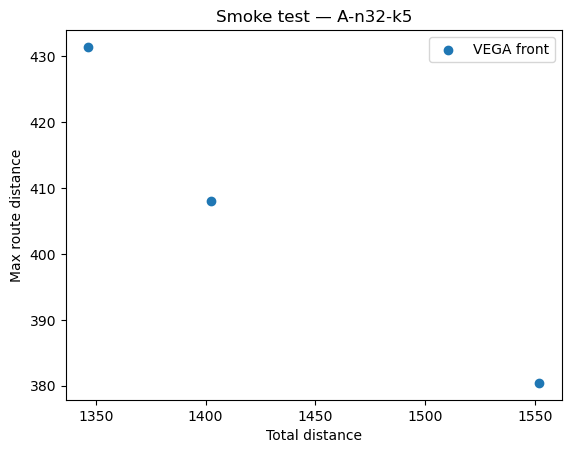

In [9]:
# === QUICK SMOKE TEST (A-n32-k5) ===
# Krever: numpy, matplotlib, vrplib (pip install numpy matplotlib vrplib)

# (i notebook)
try:
    get_ipython  # noqa
    %matplotlib inline
except Exception:
    pass

import math, time
import numpy as np
import matplotlib.pyplot as plt

# 1) Last instanser via vrplib
try:
    import vrplib
except ImportError:
    raise SystemExit("vrplib mangler. Kjør: pip install vrplib")

def from_vrplib(d):
    coords  = {i+1: (float(x), float(y)) for i,(x,y) in enumerate(d["node_coord"])}
    demands = {i+1: int(v) for i, v in enumerate(d["demand"])}
    depot   = int(d["depot"][0]) if isinstance(d["depot"], (list,tuple,np.ndarray)) else int(d["depot"])
    return {
        "name": d.get("name","UNKNOWN"),
        "capacity": int(d["capacity"]),
        "coords": coords,
        "demands": demands,
        "depot": depot,
        "dimension": int(d.get("dimension", len(coords))),
    }

def load_three():
    A = from_vrplib(vrplib.read_instance("data/A-n32-k5.vrp"))
    B = from_vrplib(vrplib.read_instance("data/B-n78-k10.vrp"))
    X = from_vrplib(vrplib.read_instance("data/X-n101-k25.vrp"))
    return [A,B,X]

try:
    instances = load_three()
except FileNotFoundError as e:
    raise SystemExit(f"Finner ikke VRP-fil: {e}\nSjekk at filene ligger i ./data/")

inst = instances[0]  # A-n32-k5
print("Instances:", [i["name"] for i in instances])

# 2) Små hjelpefunksjoner
def euclidean(a, b): return math.hypot(a[0]-b[0], a[1]-b[1])

def build_distance_matrix(inst):
    n = inst["dimension"]
    xs = np.zeros((n+1, 2), dtype=float)
    for i,(x,y) in inst["coords"].items():
        xs[i] = (x,y)
    D = np.zeros((n+1, n+1), dtype=float)
    for i in range(1, n+1):
        for j in range(1, n+1):
            D[i,j] = euclidean(xs[i], xs[j])
    return D

def split_routes_by_capacity(perm, inst):
    routes, cur, load = [], [], 0
    cap = inst["capacity"]
    for node in perm:
        d = inst["demands"][node]
        if load + d <= cap:
            cur.append(node); load += d
        else:
            if cur: routes.append(cur)
            cur = [node]; load = d
    if cur: routes.append(cur)
    return routes

def evaluate_routes(routes, inst, D):
    total = 0.0; maxlen = 0.0; depot = inst["depot"]
    for r in routes:
        if not r: continue
        length = 0.0; prev = depot
        for node in r:
            length += D[prev, node]
            prev = node
        length += D[prev, depot]
        total += length
        if length > maxlen: maxlen = length
    return total, maxlen

def pareto_filter(points):
    def dom(a,b): return all(x<=y for x,y in zip(a,b)) and any(x<y for x,y in zip(a,b))
    keep = []
    for i,p in enumerate(points):
        if any(dom(q,p) for q in points if q is not p):
            continue
        keep.append(p)
    return keep

# 3) Minimal VEGA (brukes bare hvis VEGA ikke finnes fra før)
if "VEGA" not in globals():
    class VEGA:
        def __init__(self, pop_size, num_objectives, gene_size, crossover_rate, mutation_rate, inst, rng_seed=0):
            assert pop_size % num_objectives == 0
            self.pop_size = pop_size
            self.subpop_size = pop_size // num_objectives
            self.crossover_rate = crossover_rate
            self.mutation_rate = mutation_rate
            self.inst = inst
            self.rng = np.random.RandomState(rng_seed)
            self.D = build_distance_matrix(inst)
            # init perm-pop (uten depot)
            customers = [i for i in range(1, inst["dimension"]+1) if i != inst["depot"]]
            pop = []
            for _ in range(pop_size):
                p = customers[:]; self.rng.shuffle(p); pop.append(p)
            self.population = np.array(pop, dtype=np.int32)

        def evaluate_fitness(self, individual):
            routes = split_routes_by_capacity(individual.tolist(), self.inst)
            return list(evaluate_routes(routes, self.inst, self.D))  # [total, maxlen]

        def vega_selection(self, fitness_values):
            sel_idx = []
            # obj0: total distance (min), obj1: max route distance (min)
            for obj in (0,1):
                idx = np.argsort(fitness_values[:, obj])[:self.subpop_size]
                sel_idx.extend(idx.tolist())
            return self.population[sel_idx]

        def crossover(self, p1, p2):
            if self.rng.rand() >= self.crossover_rate:
                return p1.copy()
            n = len(p1)
            a,b = sorted(self.rng.choice(n, 2, replace=False))
            child = np.full(n, -1, dtype=np.int32)
            child[a:b+1] = p1[a:b+1]
            pos = (b+1) % n
            for x in list(p2) + list(p2):
                if x not in child:
                    child[pos] = x
                    pos = (pos+1) % n
                    if pos == (b+1) % n: break
            return child

        def mutate(self, ind):
            if self.rng.rand() < self.mutation_rate:
                i,j = self.rng.choice(len(ind), 2, replace=False)
                ind = ind.copy()
                ind[i], ind[j] = ind[j], ind[i]
            return ind

        def run(self, generations):
            pop = self.population
            for _ in range(generations):
                fits = np.array([self.evaluate_fitness(ind) for ind in pop], dtype=float)
                sel = self.vega_selection(fits)
                children = []
                while len(children) < self.pop_size:
                    i,j = self.rng.choice(len(sel), 2, replace=False)
                    c = self.crossover(sel[i], sel[j])
                    c = self.mutate(c)
                    children.append(c)
                pop = np.array(children, dtype=np.int32)
            self.population = pop
            return pop

# 4) Kjør liten VEGA-kjøring på A-n32-k5 og plott
vega = VEGA(
    pop_size=20, num_objectives=2, gene_size=inst["dimension"]-1,
    crossover_rate=0.7, mutation_rate=0.2, inst=inst, rng_seed=0
)
pop = vega.run(generations=10)

objs = [vega.evaluate_fitness(ind) for ind in pop]          # [(total, maxlen), ...]
front = pareto_filter([tuple(o[:2]) for o in objs])          # bare (total,maxlen)

print(f"Instance: {inst['name']}")
print(f"Front size: {len(front)}")
print("Sample points:", front[:5])

plt.scatter([p[0] for p in front], [p[1] for p in front], label="VEGA front")
plt.xlabel("Total distance"); plt.ylabel("Max route distance")
plt.title(f"Smoke test — {inst['name']}")
plt.legend(); plt.show()




## Full Study (≥ 20 runs)

In [ ]:
# # Recommended settings for the full run
# CONFIG["runs_per_instance"] = 20
# CONFIG["pop_size"] = 100
# CONFIG["generations"] = 500
# CONFIG["cx_prob"] = 0.7
# CONFIG["mut_prob"] = 0.2
#
# instances = load_instances()
# df, store = experiment(instances)
# summarize_results(df)
# for inst in instances:
#     plot_pareto_example(store, inst.name)
#
# out_csv = "/mnt/data/vega_cvrp_results_fullstudy.csv"
# df.to_csv(out_csv, index=False)
# print("Saved:", out_csv)
